# Imports
If you don't have them already, please install these packages: `pandas scikit-learn scipy matplotlib jupyter fastparquet tqdm`

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm
from joblib import Memory

/home/jgould/miniconda3/envs/hms_hackathon/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the dataset
You can read about the complete dataset [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/data), and view a more comprehensive starter notebook [here](https://www.kaggle.com/code/awsaf49/hms-hbac-kerascv-starter-notebook/notebook); this simplified version should be enough to get you started, though.

In short, in this dataset, we're looking at 10-second clips of spectrograms of EEG recordings from patients with epilepsy.
The clips have been labeled by a team of experts as showing a seizure, lateralized periodic discharge (lpd), generalized periodic discharge (gpd), lateralized rhythmic delta activity (lrda), generalized rhythmic delta activity (grda), or other.
The metadata about the spectrograms is stored in `train.csv`, which we will load into a Pandas dataframe, `df`.

Interesting columns of `df` include:
* `patient_id`, which identifies which patient the clip was recorded from
* `[seizure/lpd/gpd/lrda/grda/other]_vote`, which shows how the annotators voted
* `expert_consensus`, which shows what class of activity the plurality of annotators chose for a given clip
* `class_label`, which is an integer-coded version of the `expert_consensus` column

Most of the other columns are about where data is stored.

In [2]:
csv_path = Path("train.csv")  # this should be the location of the csv
spectrogram_path = Path("train_spectrograms") # this should be the location of a folder


df = pd.read_csv(csv_path)
df['spec_path'] = spectrogram_path / (df['spectrogram_id'].astype(str) + '.parquet')

df['class_name'] = df.expert_consensus.copy()
label2name = dict(enumerate(df['class_name'].unique()))
name2label = {v: k for k, v in label2name.items()}
df['class_label'] = df.expert_consensus.map(name2label)

df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spec_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,train_spectrograms/353733.parquet,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,train_spectrograms/353733.parquet,Seizure,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,train_spectrograms/353733.parquet,Seizure,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,train_spectrograms/353733.parquet,Seizure,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,train_spectrograms/353733.parquet,Seizure,0


# Inspecting a spectrogram
Spectrograms are stored in parquet files, and can be loaded using the process outlined below; however, if you're impatient, you can use the get_spectrogram function at the end of this section.

First, we load the file referenced in the dataframe:

In [3]:
i = df.index[0]  # this will usually be 0, but be careful with indexing if you split your df into a train/test split
path = df.loc[i, 'spec_path']

parquet_table = pd.read_parquet(path).drop(columns=['time'])

parquet_table

,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,19.049999,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,8.460000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,21.719999,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,19.629999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,13.310000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,6.36,6.59,6.60,7.30,4.48,8.400000,13.420000,13.85,16.010000,17.730000,...,0.14,0.05,0.06,0.04,0.04,0.04,0.05,0.05,0.08,0.11
316,4.90,8.80,8.22,5.83,10.21,10.580000,10.250000,13.68,19.549999,18.980000,...,0.16,0.08,0.06,0.06,0.07,0.04,0.06,0.09,0.07,0.08
317,6.07,7.85,11.26,9.20,8.18,9.130000,10.450000,15.09,23.020000,23.840000,...,0.15,0.13,0.13,0.13,0.10,0.08,0.07,0.09,0.17,0.12
318,3.41,3.75,4.80,6.45,6.70,7.960000,8.160000,6.97,9.700000,12.290000,...,0.13,0.11,0.13,0.07,0.11,0.12,0.09,0.16,0.19,0.19


The columns of the table show the eeg reigon the spectrogram was recorded from and the frequency bin this column corresponds to.

In [4]:
rearranged_columns = parquet_table.columns.to_numpy().reshape((-1, 100))
frequencies = np.array([float(column.split('_')[1]) for column in rearranged_columns[0]])
regions = [column.split('_')[0] for column in rearranged_columns[:, 0]]
rearranged_columns

array([['LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56',
        'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73',
        'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91',
        'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08',
        'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25',
        'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 'LL_7.42',
        'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 'LL_8.59',
        'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 'LL_9.77',
        'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74',
        'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72',
        'LL_11.91', 'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7',
        'LL_12.89', 'LL_13.09', 'LL_13.28', 'LL_13.48', 'LL_13.67',
        'LL_13.87', 'LL_14.06', 'LL_14.26', 'LL_14.45', 'LL_14.65',
        'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 'LL_15.63',
        

Using this information, we can plot the spectrogram for each region:

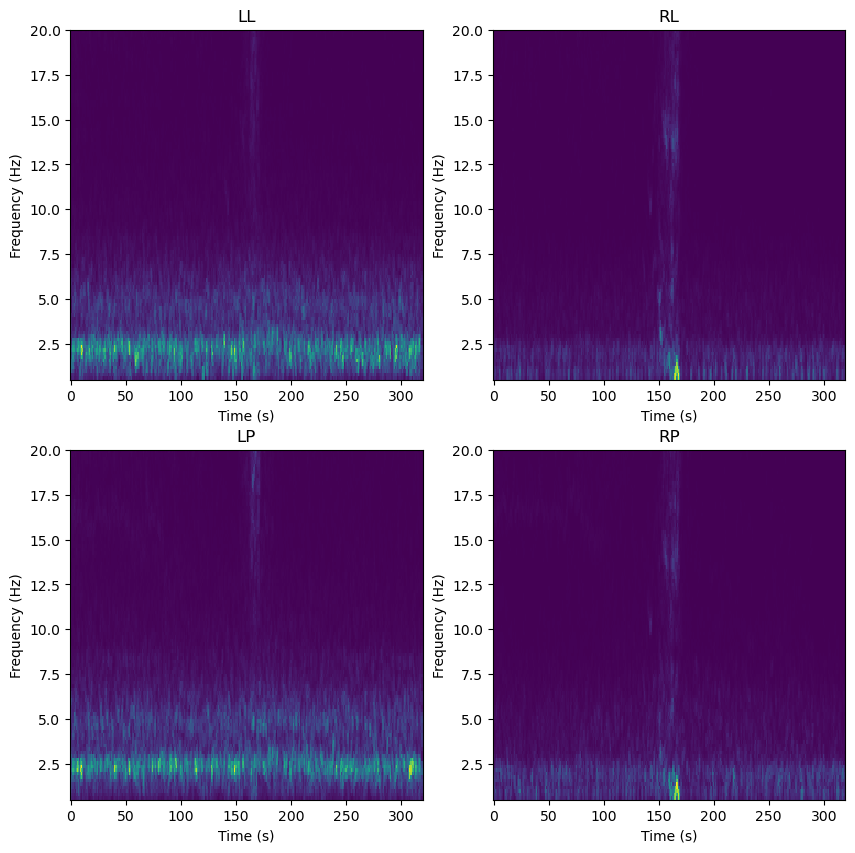

In [5]:
arr = np.array(parquet_table)
arr = arr.T.reshape(4, 100, -1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, region in enumerate(regions):
    ax = axs.flat[i]
    ax.pcolormesh(np.arange(arr.shape[2]), frequencies, arr[i], shading='nearest')
    ax.set_title(region)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')


The clips referenced in `df` are slices of the whole spectrograms; we can access the slices like so:

In [6]:
offset = df.loc[i, 'spectrogram_label_offset_seconds']
offset = int(offset // 2)
arr = arr[:, :, offset:offset + 300]

And finally, it's often useful to clip and log-scale the spectogram values:

In [7]:
arr = np.clip(arr, a_min=np.exp(-4), a_max=np.exp(8))
arr = np.log(arr)
arr[~np.isfinite(arr)] = 0

Putting this all together, we get the `get_spectrogram` function below.

Since this can be slow when we have many spectrograms to load, we also use joblib's `Memory` object to save the results for next time this spectrogram gets accessed.

In [8]:
memory = Memory(location='cache', verbose=0)


@memory.cache
def get_spectrogram(i):
    path = df.loc[i, 'spec_path']
    offset = df.loc[i, 'spectrogram_label_offset_seconds']

    arr = np.array(pd.read_parquet(path).drop(columns=['time']))
    arr = arr.T.reshape(4, 100, -1)
    offset = int(offset // 2)
    arr = arr[:, :, offset:offset + 300]

    arr = np.clip(arr, a_min=np.exp(-4), a_max=np.exp(8))
    arr = np.log(arr)
    arr[~np.isfinite(arr)] = 0
    return arr

# Analysis

Your work goes here; the code below shows the sects of an SVM classification analysis.

We encourage you to think of an interesting question with this dataset; don't feel limited to just trying to classify seizure. Other cool ideas could be to see if you can:
* cluster spectrograms by patient
* forecast the rest of the spectrogram time series given the first half
* predict which kinds of features make the experts disagree
* find an intuitive dimension-reduced embedding of the spectrograms

We encourage you to be creative, and have fun!

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

100%|██████████| 1000/1000 [00:23<00:00, 43.37it/s]


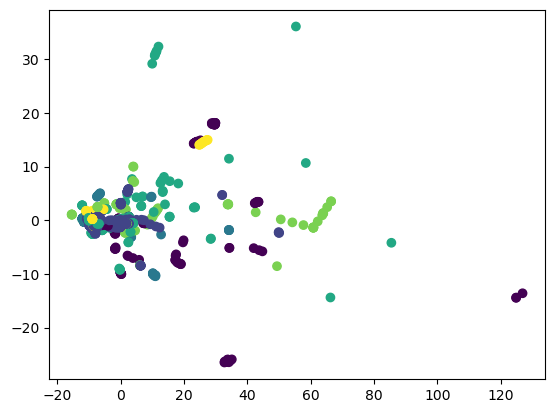

In [10]:
# this should be faster the second time it runs because of the caching
means = np.array([get_spectrogram(i).std(axis=2).flatten() for i in tqdm.trange(1000)])

normalized_means = StandardScaler().fit_transform(means)

pca = PCA(10)
reduced = pca.fit_transform(normalized_means)

plt.scatter(reduced[:, 0], reduced[:, 1], c=df.class_label[:1000])

In [11]:
clf = SVC()

clf.fit(reduced, df.class_label[:1000])  # you would probably want to do cross-validation here

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [12]:
(clf.predict(reduced) == df.class_label[:1000]).mean()  # you would probably want to evaluate on held-out data here, and use more metrics than just accuracy

np.float64(0.87)